### Imports

In [46]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import layers
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [63]:
def load_dataset():
     # load dataset
     (X_train, y_train), (X_test, y_test) = mnist.load_data()
     return (X_train, y_train), (X_test, y_test)

def preprocess(images, resize_shape):
    # reshape dataset to have a single channel
    images = tf.expand_dims(images, axis=3)
    # repeat the gray scale number to represent the image as an RGB
    images = tf.repeat(images, repeats=3, axis=3)
    # resize the images
    images = tf.image.resize(images, size=resize_shape)
    # saturate the images to gray scale values of 0,255
    images = tf.where(images > 128, 255*tf.ones_like(images), tf.zeros_like(images))
    return images



# scales images to the [0,1] range
def scale_images(images):
	# convert from integers to floats
	#images_norm = images.astype('float32')
	# normalize to range 0-1
	images_norm = images / 255.0
	# return normalized images
	return images_norm

### Pre-processing

In [64]:
# load dataset
(X_train, Y_train), (X_test, Y_test) = load_dataset()
X_train = preprocess(X_train, resize_shape=[105,105])
X_test = preprocess(X_test, resize_shape=[105,105])
# summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, Y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, Y_test.shape))


Train: X=(60000, 105, 105, 3), y=(60000,)
Test: X=(10000, 105, 105, 3), y=(10000,)


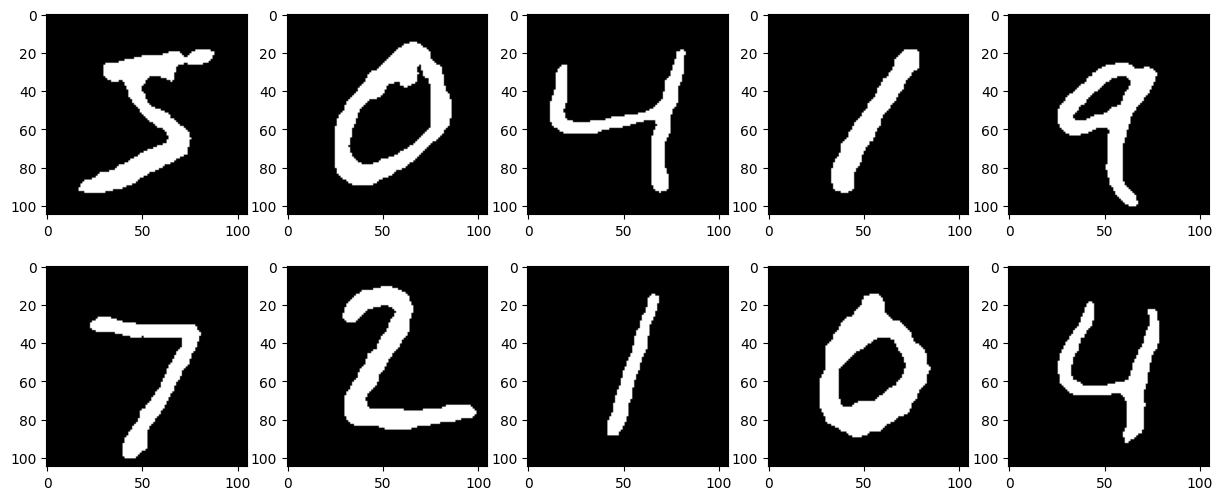

In [65]:
fig, ax = plt.subplots(2,5,figsize=(15, 6))
for i in range(5):
    ax[0,i].imshow(X_train[i].numpy().astype("uint8"))
    ax[1,i].imshow(X_test[i].numpy().astype("uint8"))

In [66]:
X_train = scale_images(X_train)
X_test = scale_images(X_test)

### Model definition

In [69]:
nmist_class_model = keras.Sequential(
    [
        keras.Input(shape=X_train.shape[1:]),
        layers.Conv2D(32, (3,3), strides=2, activation="relu", kernel_initializer='he_uniform'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3,3), strides=2, activation='relu', kernel_initializer='he_uniform'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(name='flatten_layer'),
        layers.Dense(10, activation='softmax')
    ]
)
nmist_class_model.summary()

nmist_class_model.compile(
    optimizer=keras.optimizers.Adam(),
    # Loss function to minimize
    loss=keras.losses.CategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.CategoricalAccuracy()],
)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 52, 52, 32)        896       
                                                                 
 batch_normalization_16 (Bat  (None, 52, 52, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 26, 26, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 batch_normalization_17 (Bat  (None, 12, 12, 64)       256       
 chNormalization)                                                
                                                      

In [70]:
print("Fit model on training data")
earlyStopping = EarlyStopping(monitor='val_categorical_accuracy', patience=2, verbose=0, mode='max')
mcp_save = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
history = nmist_class_model.fit(
    X_train,
    to_categorical(Y_train),
    batch_size=64,
    epochs=7,
    callbacks=[earlyStopping, mcp_save],
    validation_split=0.25)

Fit model on training data
Epoch 1/7
704/704 [==============================] - 56s 78ms/step - loss: 0.2448 - categorical_accuracy: 0.9265 - val_loss: 0.1228 - val_categorical_accuracy: 0.9629
Epoch 2/7
704/704 [==============================] - 58s 82ms/step - loss: 0.0813 - categorical_accuracy: 0.9755 - val_loss: 0.1122 - val_categorical_accuracy: 0.9664
Epoch 3/7
704/704 [==============================] - 61s 87ms/step - loss: 0.0557 - categorical_accuracy: 0.9820 - val_loss: 0.1125 - val_categorical_accuracy: 0.9697
Epoch 4/7
704/704 [==============================] - 65s 93ms/step - loss: 0.0400 - categorical_accuracy: 0.9870 - val_loss: 0.1155 - val_categorical_accuracy: 0.9697
Epoch 5/7
704/704 [==============================] - 64s 92ms/step - loss: 0.0335 - categorical_accuracy: 0.9890 - val_loss: 0.0934 - val_categorical_accuracy: 0.9769
Epoch 6/7
704/704 [==============================] - 64s 91ms/step - loss: 0.0230 - categorical_accuracy: 0.9921 - val_loss: 0.1263 - val_

In [71]:
# Evaluate the model on the test data
print("Evaluate on test data")
model = keras.models.load_model('best_model.h5')
results = model.evaluate(X_test, to_categorical(Y_test), batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
79/79 [==============================] - 3s 30ms/step - loss: 0.0844 - categorical_accuracy: 0.9794
test loss, test acc: [0.08437081426382065, 0.9793999791145325]


In [72]:
# save the model
model_checkpoint_dir = "c:/model_checkpoints/"
if os.path.isdir(model_checkpoint_dir) is not True:
    os.mkdir(model_checkpoint_dir)
model_path = os.path.join(model_checkpoint_dir,'mnist_classification_convnet')
model.save(model_path)

INFO:tensorflow:Assets written to: c:/model_checkpoints/mnist_classification_convnet\assets


INFO:tensorflow:Assets written to: c:/model_checkpoints/mnist_classification_convnet\assets


### classify NMIST using a centroid similarity approach

In [73]:
feature_extractor = keras.Model(inputs=model.inputs, outputs=model.get_layer(name="flatten_layer").output)

In [74]:
from utils.experiment_utils import extract_features
# define an identity function as preprocess function for the test images
def identity(images):
    return images
batch_size = 32
with tf.device('/cpu:0'):
    test_ds = tf.data.Dataset.from_tensor_slices(X_test).batch(batch_size)
X_test_features = extract_features(ds=test_ds, preprocessing_model=identity, feature_extractor=feature_extractor)

Measuring accuracy with 10 classes,  5 training examples per class
---------------------------------------------------------------




Measuring accuracy with 10 classes,  10 training examples per class
---------------------------------------------------------------






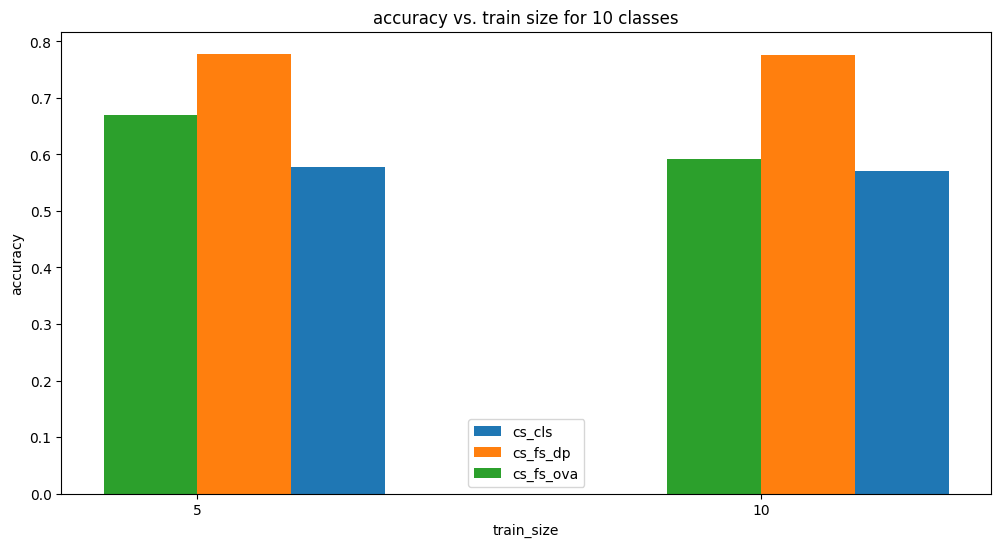

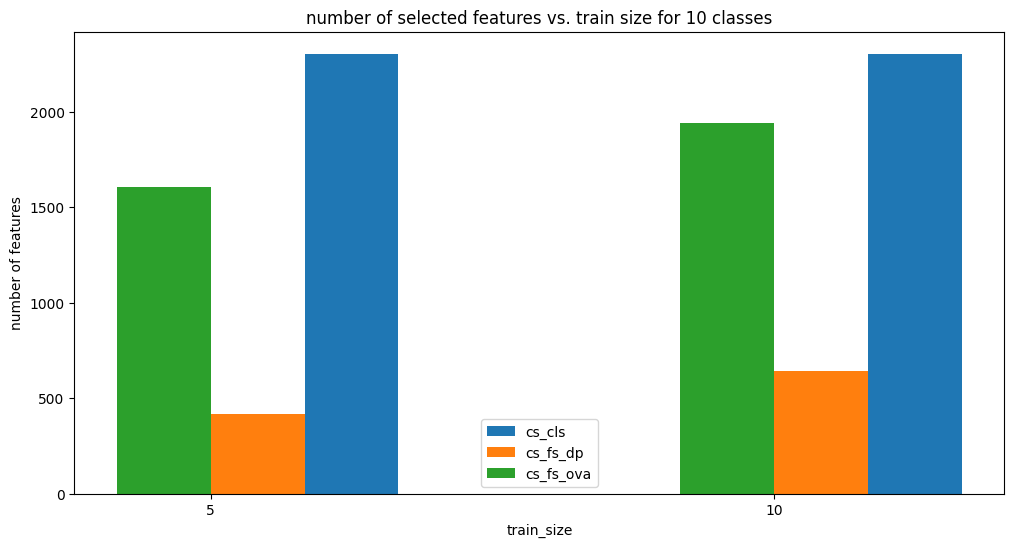

In [75]:
from lib.similarity import CentroidSimilarity
from lib.classifier_with_feature_selection import ClassifierFeatureSelection
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova, FeatureSelectionDiversityPursuitPermutation, FeatureSelectionDiversityPursuitKruskal
from utils.experiment_utils import multiple_classifiers_fit_predict
from utils.visualization import bar_plot_scores
gamma = 0.2
train_sizes = [5,10]
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
dp_perm_fs = FeatureSelectionDiversityPursuitPermutation(hc_gamma=gamma, n_resamples=5000)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(CentroidSimilarity(), dp_fs)
#cs_fs_dp_perm = ClassifierFeatureSelection(cs_cls, dp_perm_fs)
cs_fs_ova = ClassifierFeatureSelection(CentroidSimilarity(), ova_fs)

classifiers = [cs_cls, cs_fs_dp, cs_fs_ova]
num_experiments = 50
# define possible sizes for the train set (number of train examples per class)
num_classes = 10
accuracies = np.empty((len(classifiers),len(train_sizes),num_experiments))
accuracies_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))

for i in range(len(train_sizes)):

    print(f"Measuring accuracy with {num_classes} classes,  {train_sizes[i]} training examples per class")
    print("---------------------------------------------------------------")
    for j in range(num_experiments):
        smpl_X_train, smpl_X_test, smpl_y_train, smpl_y_test = train_test_split(X_test_features, Y_test, train_size=train_sizes[i]*num_classes, stratify=Y_test)
        accuracies[:,i,j], num_features[:,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers,
                                                                                              X_train=smpl_X_train,
                                                                                              y_train=smpl_y_train,
                                                                                              X_test=smpl_X_test,
                                                                                              y_test=smpl_y_test)


    print("\n\n\n")


bar_labels = ['cs_cls', 'cs_fs_dp', 'cs_fs_ova']
bar_plot_scores(scores=np.mean(accuracies,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'accuracy vs. train size for {num_classes} classes')

bar_plot_scores(scores=np.mean(num_features,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes')